In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

(1, 3, 3, 1)


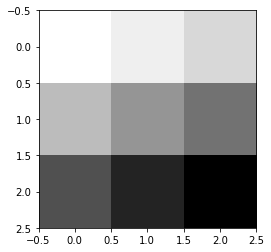

In [2]:
sess = tf.InteractiveSession()
image = np.array([[[[1],[2],[3]],
                   [[4],[5],[6]], 
                   [[7],[8],[9]]]], dtype=np.float32)
print(image.shape)
plt.imshow(image.reshape(3,3), cmap='Greys')

#(1, 3, 3, 1) : n개의 이미지, 가로, 세로, 색상 수 = 3x3의 단일 색상을 사용하는 이미지 1개

# Simple convolution layer

<img src="Images/lab11_1.png">

In [3]:
import random
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
# Check out https://www.tensorflow.org/get_started/mnist/beginners for
# more information about the mnist dataset

# hyper parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

# input place holders
X = tf.placeholder(tf.float32, [None, 784]) #n개를 불러온다. 각 784개의 요소로 되어 있다.
X_img = tf.reshape(X, [-1, 28, 28, 1])   # img 28x28x1 (black/white). 
#reshape. -1(n)개의 이미지, 28x28, 1개의 색상으로 이루어진 이미지
Y = tf.placeholder(tf.float32, [None, 10])

# L1 ImgIn shape=(?, 28, 28, 1) : 이미지의 인풋
W1 = tf.Variable(tf.random_normal([3, 3, 1, 32], stddev=0.01)) #가중치. 필터 (3x3, 단색(이미지의 색상과 같아야 한다), 32개의 필터)
#    Conv     -> (?, 28, 28, 32)
#    Pool     -> (?, 14, 14, 32) : Stride가 1x1이 아니므로 패딩 옵션을 SAME으로 했어도 28x28로 나오지 않는다.
L1 = tf.nn.conv2d(X_img, W1, strides=[1, 1, 1, 1], padding='SAME') #CNN 구현. 이미지, 가중치(필터), 패딩
#패딩 옵션 SAME은 스트라이드가 1일 때 인풋 이미지 크기와 같은 아웃풋이 나오도록 패딩을 설정해 준다.
#스트라이드가 1x1이 아니라면 패딩 옵션을 SAME으로 해도 출력 이미지의 크기가 줄어든다.
#필터의 수 만큼 이미지가 출력된다. 여기서는 필터가 5개 이므로 5개의 각각 조금씩 다른 이미지가 나오게 된다.
L1 = tf.nn.relu(L1) #Relu
L1 = tf.nn.max_pool(L1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME') #풀링. 풀링 때도 패딩을 줘서 출력값 같도록

'''
Tensor("Conv2D:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("Relu:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)
'''

# L2 ImgIn shape=(?, 14, 14, 32) : L1의 마지막 (Pooling 아웃풋)
W2 = tf.Variable(tf.random_normal([3, 3, 32, 64], stddev=0.01)) #가중치. 필터 (3x3, 색상(layer1에서 부터), 64개의 필터)
#    Conv      ->(?, 14, 14, 64)
#    Pool      ->(?, 7, 7, 64)
L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding='SAME')
L2 = tf.nn.relu(L2)
L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
L2_flat = tf.reshape(L2, [-1, 7 * 7 * 64]) #FC로 연결하기 전에 reshape해서 펼친다. n개, 7 * 7 * 64 = 3136
#결국 784개 요소로 된 이미지에서 (28x28) 3136개의 FC 인풋이 나온다.

'''
Tensor("Conv2D_1:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("Relu_1:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("MaxPool_1:0", shape=(?, 7, 7, 64), dtype=float32)
Tensor("Reshape_1:0", shape=(?, 3136), dtype=float32)
'''

# Final FC 7x7x64 inputs -> 10 outputs
#CNN이후 일반 FC로 연결해서 분류
W3 = tf.get_variable("W3", shape=[7 * 7 * 64, 10], initializer=tf.contrib.layers.xavier_initializer()) 
#그 이후는 일반 FC와 같다. 가중치의 shape는 7 * 7 * 64, 출력값 10(10개 중 분류)
b = tf.Variable(tf.random_normal([10])) #편향은 출력값과 같다.
logits = tf.matmul(L2_flat, W3) + b #내적

# define cost/loss & optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y)) #cross entropy
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) #Adam으로 최적화

# initialize
sess = tf.Session()
sess.run(tf.global_variables_initializer()) #초기화

# train my model
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(mnist.train.num_examples / batch_size)

    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        feed_dict = {X: batch_xs, Y: batch_ys}
        c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
        avg_cost += c / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning Finished!')

# Test model and check accuracy
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('Accuracy:', sess.run(accuracy, feed_dict={
      X: mnist.test.images, Y: mnist.test.labels}))

# Get one and predict
r = random.randint(0, mnist.test.num_examples - 1)
print("Label: ", sess.run(tf.argmax(mnist.test.labels[r:r + 1], 1)))
print("Prediction: ", sess.run(
    tf.argmax(logits, 1), feed_dict={X: mnist.test.images[r:r + 1]}))

# plt.imshow(mnist.test.images[r:r + 1].
#           reshape(28, 28), cmap='Greys', interpolation='nearest')
# plt.show()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Learning started. It takes sometime.
Epoch: 0001 cost = 0.398426641
Epoch: 0002 cost = 0.096854105
Epoch: 0003 cost = 0.071117939
Epoch: 0004 cost = 0.058484725
Epoch: 0005 cost = 0.049934692
Epoch: 0006 cost = 0.042859572
Epoch: 0007 cost = 0.037695158
Epoch: 0008 cost = 0.033621164
Epoch: 0009 cost = 0.028893373
Epoch: 0010 cost = 0.026547855
Epoch: 0011 cost = 0.022195014
Epoch: 0012 cost = 0.019178468
Epoch: 0013 cost = 0.017505269
Epoch: 0014 cost = 0.016176422
Epoch: 0015 cost = 0.013374806
Learning Finished!
Accuracy: 0.9879
Label:  [1]
Prediction:  [1]


# Deep CNN
<img src="Images/lab11_2.png">

In [4]:
# hyper parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

# dropout (keep_prob) rate  0.7~0.5 on training, but should be 1 for testing
keep_prob = tf.placeholder(tf.float32)

# input place holders
X = tf.placeholder(tf.float32, [None, 784])
X_img = tf.reshape(X, [-1, 28, 28, 1])   # img 28x28x1 (black/white)
Y = tf.placeholder(tf.float32, [None, 10])

# L1 ImgIn shape=(?, 28, 28, 1)
W1 = tf.Variable(tf.random_normal([3, 3, 1, 32], stddev=0.01))
#    Conv     -> (?, 28, 28, 32)
#    Pool     -> (?, 14, 14, 32)
L1 = tf.nn.conv2d(X_img, W1, strides=[1, 1, 1, 1], padding='SAME')
L1 = tf.nn.relu(L1)
L1 = tf.nn.max_pool(L1, ksize=[1, 2, 2, 1],
                    strides=[1, 2, 2, 1], padding='SAME')
L1 = tf.nn.dropout(L1, keep_prob=keep_prob)
'''
Tensor("Conv2D:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("Relu:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)
Tensor("dropout/mul:0", shape=(?, 14, 14, 32), dtype=float32)
'''

# L2 ImgIn shape=(?, 14, 14, 32)
W2 = tf.Variable(tf.random_normal([3, 3, 32, 64], stddev=0.01))
#    Conv      ->(?, 14, 14, 64)
#    Pool      ->(?, 7, 7, 64)
L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding='SAME')
L2 = tf.nn.relu(L2)
L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1],
                    strides=[1, 2, 2, 1], padding='SAME')
L2 = tf.nn.dropout(L2, keep_prob=keep_prob)
'''
Tensor("Conv2D_1:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("Relu_1:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("MaxPool_1:0", shape=(?, 7, 7, 64), dtype=float32)
Tensor("dropout_1/mul:0", shape=(?, 7, 7, 64), dtype=float32)
'''

# L3 ImgIn shape=(?, 7, 7, 64)
W3 = tf.Variable(tf.random_normal([3, 3, 64, 128], stddev=0.01))
#    Conv      ->(?, 7, 7, 128)
#    Pool      ->(?, 4, 4, 128)
#    Reshape   ->(?, 4 * 4 * 128) # Flatten them for FC
L3 = tf.nn.conv2d(L2, W3, strides=[1, 1, 1, 1], padding='SAME')
L3 = tf.nn.relu(L3)
L3 = tf.nn.max_pool(L3, ksize=[1, 2, 2, 1], strides=[
                    1, 2, 2, 1], padding='SAME')
L3 = tf.nn.dropout(L3, keep_prob=keep_prob)
L3_flat = tf.reshape(L3, [-1, 128 * 4 * 4])
'''
Tensor("Conv2D_2:0", shape=(?, 7, 7, 128), dtype=float32)
Tensor("Relu_2:0", shape=(?, 7, 7, 128), dtype=float32)
Tensor("MaxPool_2:0", shape=(?, 4, 4, 128), dtype=float32)
Tensor("dropout_2/mul:0", shape=(?, 4, 4, 128), dtype=float32)
Tensor("Reshape_1:0", shape=(?, 2048), dtype=float32)
'''

# L4 FC 4x4x128 inputs -> 625 outputs
W4 = tf.get_variable("W4", shape=[128 * 4 * 4, 625],
                     initializer=tf.contrib.layers.xavier_initializer())
b4 = tf.Variable(tf.random_normal([625]))
L4 = tf.nn.relu(tf.matmul(L3_flat, W4) + b4)
L4 = tf.nn.dropout(L4, keep_prob=keep_prob)
'''
Tensor("Relu_3:0", shape=(?, 625), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 625), dtype=float32)
'''

# L5 Final FC 625 inputs -> 10 outputs
W5 = tf.get_variable("W5", shape=[625, 10],
                     initializer=tf.contrib.layers.xavier_initializer())
b5 = tf.Variable(tf.random_normal([10]))
logits = tf.matmul(L4, W5) + b5
'''
Tensor("add_1:0", shape=(?, 10), dtype=float32)
'''

# define cost/loss & optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# initialize
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# train my model
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(mnist.train.num_examples / batch_size)

    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        feed_dict = {X: batch_xs, Y: batch_ys, keep_prob: 0.7}
        c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
        avg_cost += c / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning Finished!')

# Test model and check accuracy

# if you have a OOM error, please refer to lab-11-X-mnist_deep_cnn_low_memory.py

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('Accuracy:', sess.run(accuracy, feed_dict={
      X: mnist.test.images, Y: mnist.test.labels, keep_prob: 1}))

# Get one and predict
r = random.randint(0, mnist.test.num_examples - 1)
print("Label: ", sess.run(tf.argmax(mnist.test.labels[r:r + 1], 1)))
print("Prediction: ", sess.run(
    tf.argmax(logits, 1), feed_dict={X: mnist.test.images[r:r + 1], keep_prob: 1}))

# plt.imshow(mnist.test.images[r:r + 1].
#           reshape(28, 28), cmap='Greys', interpolation='nearest')
3# plt.show()

Learning started. It takes sometime.
Epoch: 0001 cost = 0.549299927
Epoch: 0002 cost = 0.097824201
Epoch: 0003 cost = 0.074171673
Epoch: 0004 cost = 0.061046716
Epoch: 0005 cost = 0.054625241
Epoch: 0006 cost = 0.045836637
Epoch: 0007 cost = 0.041874533
Epoch: 0008 cost = 0.037723221
Epoch: 0009 cost = 0.035936798
Epoch: 0010 cost = 0.032871616
Epoch: 0011 cost = 0.032102569
Epoch: 0012 cost = 0.029221111
Epoch: 0013 cost = 0.026423224
Epoch: 0014 cost = 0.027738844
Epoch: 0015 cost = 0.025987224
Learning Finished!
Accuracy: 0.9928
Label:  [5]
Prediction:  [5]


# Python Class

In [ ]:
# hyper parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100


class Model:

    def __init__(self, sess, name):
        self.sess = sess
        self.name = name
        self._build_net()

    def _build_net(self):
        with tf.variable_scope(self.name):
            # dropout (keep_prob) rate  0.7~0.5 on training, but should be 1
            # for testing
            self.keep_prob = tf.placeholder(tf.float32)

            # input place holders
            self.X = tf.placeholder(tf.float32, [None, 784])
            # img 28x28x1 (black/white)
            X_img = tf.reshape(self.X, [-1, 28, 28, 1])
            self.Y = tf.placeholder(tf.float32, [None, 10])

            # L1 ImgIn shape=(?, 28, 28, 1)
            W1 = tf.Variable(tf.random_normal([3, 3, 1, 32], stddev=0.01))
            #    Conv     -> (?, 28, 28, 32)
            #    Pool     -> (?, 14, 14, 32)
            L1 = tf.nn.conv2d(X_img, W1, strides=[1, 1, 1, 1], padding='SAME')
            L1 = tf.nn.relu(L1)
            L1 = tf.nn.max_pool(L1, ksize=[1, 2, 2, 1],
                                strides=[1, 2, 2, 1], padding='SAME')
            L1 = tf.nn.dropout(L1, keep_prob=self.keep_prob)
            '''
            Tensor("Conv2D:0", shape=(?, 28, 28, 32), dtype=float32)
            Tensor("Relu:0", shape=(?, 28, 28, 32), dtype=float32)
            Tensor("MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)
            Tensor("dropout/mul:0", shape=(?, 14, 14, 32), dtype=float32)
            '''

            # L2 ImgIn shape=(?, 14, 14, 32)
            W2 = tf.Variable(tf.random_normal([3, 3, 32, 64], stddev=0.01))
            #    Conv      ->(?, 14, 14, 64)
            #    Pool      ->(?, 7, 7, 64)
            L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding='SAME')
            L2 = tf.nn.relu(L2)
            L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1],
                                strides=[1, 2, 2, 1], padding='SAME')
            L2 = tf.nn.dropout(L2, keep_prob=self.keep_prob)
            '''
            Tensor("Conv2D_1:0", shape=(?, 14, 14, 64), dtype=float32)
            Tensor("Relu_1:0", shape=(?, 14, 14, 64), dtype=float32)
            Tensor("MaxPool_1:0", shape=(?, 7, 7, 64), dtype=float32)
            Tensor("dropout_1/mul:0", shape=(?, 7, 7, 64), dtype=float32)
            '''

            # L3 ImgIn shape=(?, 7, 7, 64)
            W3 = tf.Variable(tf.random_normal([3, 3, 64, 128], stddev=0.01))
            #    Conv      ->(?, 7, 7, 128)
            #    Pool      ->(?, 4, 4, 128)
            #    Reshape   ->(?, 4 * 4 * 128) # Flatten them for FC
            L3 = tf.nn.conv2d(L2, W3, strides=[1, 1, 1, 1], padding='SAME')
            L3 = tf.nn.relu(L3)
            L3 = tf.nn.max_pool(L3, ksize=[1, 2, 2, 1], strides=[
                                1, 2, 2, 1], padding='SAME')
            L3 = tf.nn.dropout(L3, keep_prob=self.keep_prob)

            L3_flat = tf.reshape(L3, [-1, 128 * 4 * 4])
            '''
            Tensor("Conv2D_2:0", shape=(?, 7, 7, 128), dtype=float32)
            Tensor("Relu_2:0", shape=(?, 7, 7, 128), dtype=float32)
            Tensor("MaxPool_2:0", shape=(?, 4, 4, 128), dtype=float32)
            Tensor("dropout_2/mul:0", shape=(?, 4, 4, 128), dtype=float32)
            Tensor("Reshape_1:0", shape=(?, 2048), dtype=float32)
            '''

            # L4 FC 4x4x128 inputs -> 625 outputs
            W4 = tf.get_variable("W4", shape=[128 * 4 * 4, 625],
                                 initializer=tf.contrib.layers.xavier_initializer())
            b4 = tf.Variable(tf.random_normal([625]))
            L4 = tf.nn.relu(tf.matmul(L3_flat, W4) + b4)
            L4 = tf.nn.dropout(L4, keep_prob=self.keep_prob)
            '''
            Tensor("Relu_3:0", shape=(?, 625), dtype=float32)
            Tensor("dropout_3/mul:0", shape=(?, 625), dtype=float32)
            '''

            # L5 Final FC 625 inputs -> 10 outputs
            W5 = tf.get_variable("W5", shape=[625, 10],
                                 initializer=tf.contrib.layers.xavier_initializer())
            b5 = tf.Variable(tf.random_normal([10]))
            self.logits = tf.matmul(L4, W5) + b5
            '''
            Tensor("add_1:0", shape=(?, 10), dtype=float32)
            '''

        # define cost/loss & optimizer
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            logits=self.logits, labels=self.Y))
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate=learning_rate).minimize(self.cost)

        correct_prediction = tf.equal(
            tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    def predict(self, x_test, keep_prop=1.0):
        return self.sess.run(self.logits, feed_dict={self.X: x_test, self.keep_prob: keep_prop})

    def get_accuracy(self, x_test, y_test, keep_prop=1.0):
        return self.sess.run(self.accuracy, feed_dict={self.X: x_test, self.Y: y_test, self.keep_prob: keep_prop})

    def train(self, x_data, y_data, keep_prop=0.7):
        return self.sess.run([self.cost, self.optimizer], feed_dict={
            self.X: x_data, self.Y: y_data, self.keep_prob: keep_prop})

# initialize
sess = tf.Session()
m1 = Model(sess, "m1")

sess.run(tf.global_variables_initializer())

print('Learning Started!')

# train my model
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(mnist.train.num_examples / batch_size)

    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        c, _ = m1.train(batch_xs, batch_ys)
        avg_cost += c / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning Finished!')

# Test model and check accuracy
print('Accuracy:', m1.get_accuracy(mnist.test.images, mnist.test.labels))

# tf.layers

In [ ]:
# hyper parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100


class Model:

    def __init__(self, sess, name):
        self.sess = sess
        self.name = name
        self._build_net()

    def _build_net(self):
        with tf.variable_scope(self.name):
            # dropout (keep_prob) rate  0.7~0.5 on training, but should be 1
            # for testing
            self.training = tf.placeholder(tf.bool)

            # input place holders
            self.X = tf.placeholder(tf.float32, [None, 784])

            # img 28x28x1 (black/white), Input Layer
            X_img = tf.reshape(self.X, [-1, 28, 28, 1])
            self.Y = tf.placeholder(tf.float32, [None, 10])

            # Convolutional Layer #1
            conv1 = tf.layers.conv2d(inputs=X_img, filters=32, kernel_size=[3, 3],
                                     padding="SAME", activation=tf.nn.relu)
            # Pooling Layer #1
            pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2],
                                            padding="SAME", strides=2)
            dropout1 = tf.layers.dropout(inputs=pool1,
                                         rate=0.7, training=self.training)

            # Convolutional Layer #2 and Pooling Layer #2
            conv2 = tf.layers.conv2d(inputs=dropout1, filters=64, kernel_size=[3, 3],
                                     padding="SAME", activation=tf.nn.relu)
            pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2],
                                            padding="SAME", strides=2)
            dropout2 = tf.layers.dropout(inputs=pool2,
                                         rate=0.7, training=self.training)

            # Convolutional Layer #2 and Pooling Layer #2
            conv3 = tf.layers.conv2d(inputs=dropout2, filters=128, kernel_size=[3, 3],
                                     padding="same", activation=tf.nn.relu)
            pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2],
                                            padding="same", strides=2)
            dropout3 = tf.layers.dropout(inputs=pool3,
                                         rate=0.7, training=self.training)

            # Dense Layer with Relu
            flat = tf.reshape(dropout3, [-1, 128 * 4 * 4])
            dense4 = tf.layers.dense(inputs=flat,
                                     units=625, activation=tf.nn.relu)
            dropout4 = tf.layers.dropout(inputs=dense4,
                                         rate=0.5, training=self.training)

            # Logits (no activation) Layer: L5 Final FC 625 inputs -> 10 outputs
            self.logits = tf.layers.dense(inputs=dropout4, units=10)

        # define cost/loss & optimizer
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            logits=self.logits, labels=self.Y))
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate=learning_rate).minimize(self.cost)

        correct_prediction = tf.equal(
            tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    def predict(self, x_test, training=False):
        return self.sess.run(self.logits,
                             feed_dict={self.X: x_test, self.training: training})

    def get_accuracy(self, x_test, y_test, training=False):
        return self.sess.run(self.accuracy,
                             feed_dict={self.X: x_test,
                                        self.Y: y_test, self.training: training})

    def train(self, x_data, y_data, training=True):
        return self.sess.run([self.cost, self.optimizer], feed_dict={
            self.X: x_data, self.Y: y_data, self.training: training})

# initialize
sess = tf.Session()
m1 = Model(sess, "m1")

sess.run(tf.global_variables_initializer())

print('Learning Started!')

# train my model
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(mnist.train.num_examples / batch_size)

    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        c, _ = m1.train(batch_xs, batch_ys)
        avg_cost += c / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning Finished!')

# Test model and check accuracy
print('Accuracy:', m1.get_accuracy(mnist.test.images, mnist.test.labels))

# Ensemble

각각의 모델의 결과를 낸 다음 합친다.

In [ ]:
# hyper parameters
learning_rate = 0.001
training_epochs = 20
batch_size = 100


class Model:

    def __init__(self, sess, name):
        self.sess = sess
        self.name = name
        self._build_net()

    def _build_net(self):
        with tf.variable_scope(self.name):
            # dropout (keep_prob) rate  0.7~0.5 on training, but should be 1
            # for testing
            self.training = tf.placeholder(tf.bool)

            # input place holders
            self.X = tf.placeholder(tf.float32, [None, 784])

            # img 28x28x1 (black/white), Input Layer
            X_img = tf.reshape(self.X, [-1, 28, 28, 1])
            self.Y = tf.placeholder(tf.float32, [None, 10])

            # Convolutional Layer #1
            conv1 = tf.layers.conv2d(inputs=X_img, filters=32, kernel_size=[3, 3],
                                     padding="SAME", activation=tf.nn.relu)
            # Pooling Layer #1
            pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2],
                                            padding="SAME", strides=2)
            dropout1 = tf.layers.dropout(inputs=pool1,
                                         rate=0.7, training=self.training)

            # Convolutional Layer #2 and Pooling Layer #2
            conv2 = tf.layers.conv2d(inputs=dropout1, filters=64, kernel_size=[3, 3],
                                     padding="SAME", activation=tf.nn.relu)
            pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2],
                                            padding="SAME", strides=2)
            dropout2 = tf.layers.dropout(inputs=pool2,
                                         rate=0.7, training=self.training)

            # Convolutional Layer #3 and Pooling Layer #3
            conv3 = tf.layers.conv2d(inputs=dropout2, filters=128, kernel_size=[3, 3],
                                     padding="SAME", activation=tf.nn.relu)
            pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2],
                                            padding="SAME", strides=2)
            dropout3 = tf.layers.dropout(inputs=pool3,
                                         rate=0.7, training=self.training)

            # Dense Layer with Relu
            flat = tf.reshape(dropout3, [-1, 128 * 4 * 4])
            dense4 = tf.layers.dense(inputs=flat,
                                     units=625, activation=tf.nn.relu)
            dropout4 = tf.layers.dropout(inputs=dense4,
                                         rate=0.5, training=self.training)

            # Logits (no activation) Layer: L5 Final FC 625 inputs -> 10 outputs
            self.logits = tf.layers.dense(inputs=dropout4, units=10)

        # define cost/loss & optimizer
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            logits=self.logits, labels=self.Y))
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate=learning_rate).minimize(self.cost)

        correct_prediction = tf.equal(
            tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    def predict(self, x_test, training=False):
        return self.sess.run(self.logits,
                             feed_dict={self.X: x_test, self.training: training})

    def get_accuracy(self, x_test, y_test, training=False):
        return self.sess.run(self.accuracy,
                             feed_dict={self.X: x_test,
                                        self.Y: y_test, self.training: training})

    def train(self, x_data, y_data, training=True):
        return self.sess.run([self.cost, self.optimizer], feed_dict={
            self.X: x_data, self.Y: y_data, self.training: training})

# initialize
sess = tf.Session()

models = []
num_models = 2
for m in range(num_models):
    models.append(Model(sess, "model" + str(m)))

sess.run(tf.global_variables_initializer())

print('Learning Started!')

# train my model
for epoch in range(training_epochs):
    avg_cost_list = np.zeros(len(models))
    total_batch = int(mnist.train.num_examples / batch_size)
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)

        # train each model
        for m_idx, m in enumerate(models):
            c, _ = m.train(batch_xs, batch_ys)
            avg_cost_list[m_idx] += c / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', avg_cost_list)

print('Learning Finished!')

# Test model and check accuracy
test_size = len(mnist.test.labels)
predictions = np.zeros(test_size * 10).reshape(test_size, 10)
for m_idx, m in enumerate(models):
    print(m_idx, 'Accuracy:', m.get_accuracy(
        mnist.test.images, mnist.test.labels))
    p = m.predict(mnist.test.images)
    predictions += p

ensemble_correct_prediction = tf.equal(
    tf.argmax(predictions, 1), tf.argmax(mnist.test.labels, 1))
ensemble_accuracy = tf.reduce_mean(
    tf.cast(ensemble_correct_prediction, tf.float32))
print('Ensemble accuracy:', sess.run(ensemble_accuracy))
